In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import keras
import ast
from PIL import Image, ImageDraw 
from glob import glob
from dask import bag
import os
from keras import Model, Sequential, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
from io import BytesIO
%matplotlib inline

Using TensorFlow backend.


In [2]:
fnames = ['input/train_simplified/cat.csv', 'input/train_simplified/dog.csv', 'input/train_simplified/whale.csv', 'input/train_simplified/zebra.csv', 'input/train_simplified/tiger.csv']
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:6]:
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(2)
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,VE,"[[[130, 113, 99, 109, 76, 64, 55, 48, 48, 51, ...",5201136883597312,True,2017-03-02 23:25:10.074530,cat
1,BR,"[[[222, 196, 176, 173, 179, 191, 233, 251, 255...",4647694628814848,True,2017-03-26 18:43:54.780830,cat
2,US,"[[[115, 110, 111, 130, 132, 125], [45, 52, 60,...",6718004173733888,True,2017-03-01 21:44:26.601760,dog
3,KR,"[[[66, 65, 72, 81], [48, 11, 0, 41]], [[61, 28...",5319657680535552,True,2017-03-05 10:02:39.659490,dog
4,US,"[[[103, 71, 45, 21, 6, 6, 12, 37, 26, 2, 0, 14...",5008010172694528,True,2017-03-27 13:00:34.636600,whale
5,US,"[[[130, 175, 194, 204, 223, 237, 244, 254, 255...",5139168395001856,True,2017-01-28 18:07:55.372010,whale
6,US,"[[[5, 10, 13, 14, 20, 31, 86, 112, 174, 185, 1...",5387799282843648,True,2017-03-09 22:35:47.538450,zebra
7,HU,"[[[55, 44, 13, 2, 0, 2, 12, 29, 48, 55], [36, ...",6240213758115840,True,2017-03-06 17:40:19.940810,zebra
8,GB,"[[[73, 66, 46, 23, 12, 11, 22, 48, 58, 67, 70,...",5623037611212800,True,2017-03-28 20:42:24.648040,tiger
9,AE,"[[[25, 23, 26, 35, 48, 78, 99, 112, 119, 118, ...",4875224535269376,True,2017-01-27 12:27:37.595260,tiger


In [3]:
evens = range(0,24,2)
odds = range(1,23, 2)
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

example1s
example2s

[[[[222, 196, 176, 173, 179, 191, 233, 251, 255, 250, 231, 219],
   [31, 32, 43, 60, 72, 79, 79, 69, 54, 35, 27, 27]],
  [[176, 198, 203], [42, 0, 26]],
  [[219, 238, 249, 252, 252], [29, 11, 5, 16, 43]],
  [[190, 188, 191, 200, 204, 200], [44, 45, 49, 51, 43, 41]],
  [[233, 228, 233, 241, 243, 231], [44, 48, 53, 53, 46, 43]],
  [[203, 208, 213, 218, 227, 234], [63, 69, 69, 62, 70, 62]],
  [[168, 101, 75, 54, 53, 59, 69, 132, 180, 195, 199, 197],
   [41, 50, 62, 81, 101, 108, 110, 108, 83, 67, 61, 60]],
  [[57, 16, 0, 3, 23, 28, 40, 56], [76, 101, 130, 138, 137, 100, 90, 87]],
  [[74, 75, 78, 85, 94, 97, 96], [106, 139, 143, 145, 145, 140, 106]],
  [[163, 170, 172, 177, 183, 183, 176, 175],
   [92, 132, 134, 132, 122, 104, 93, 82]]],
 [[[66, 65, 72, 81], [48, 11, 0, 41]],
  [[61, 28, 4, 7, 6, 38, 39, 1, 4, 21, 36, 54, 64, 70, 134, 151, 153],
   [48,
    50,
    58,
    70,
    90,
    77,
    103,
    134,
    137,
    141,
    140,
    131,
    118,
    104,
    104,
    102,
    100]

C:\Users\Abir Hassan\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


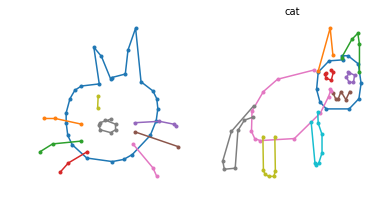

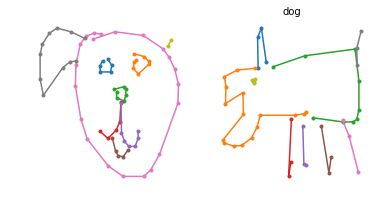

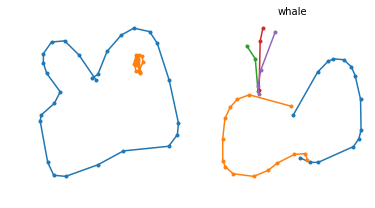

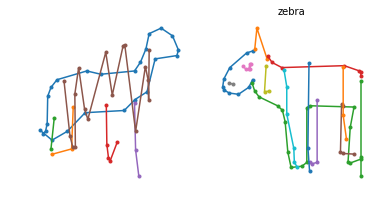

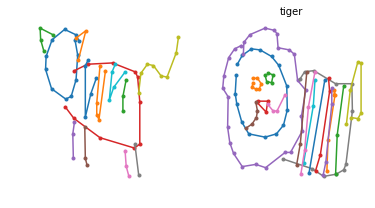

In [4]:
labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')
    plt.gca().invert_yaxis()
    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)
    plt.gca().invert_yaxis()
    plt.show()

In [5]:
#%% set global vars and params
class_files = fnames
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(class_files)}
reverse_dict = {v: k for k, v in class_dict.items()}

class_fraction = 1                     ## 
imheight, imwidth = 32, 32  
ims_per_class = 2000 

num_classes = int(len(class_files)*class_fraction)
num_classes 

5

In [6]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

#%% get train arrays
train_grand = []
class_paths = fnames
for i,c in enumerate(class_paths[0: num_classes]):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

In [7]:
# memory-friendly alternative to train_test_split?
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(9000, 5) 
 (9000, 32, 32, 1) 
 (1000, 5) 
 (1000, 32, 32, 1)


In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 680)               2785960   
__________

In [9]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

history_cb = LossHistory()

In [10]:
opt = optimizers.Adam(lr=0.01)
model.compile(optimizer=opt,
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [11]:
#model.fit(X_train, y_train, epochs=20, batch_size=42, validation_data=(X_val, y_val), callbacks=[history_cb])
model.fit(X_train, y_train,
          batch_size = 42,
          epochs = 3,
          validation_data=(X_val, y_val),
          callbacks=[history_cb])

score = model.evaluate(X_val, y_val, verbose = 1)
print("\nAccuracy {}".format(score[1]))

Train on 9000 samples, validate on 1000 samples
Epoch 1/3
9000/9000 [==============================] - 26s 3ms/step - loss: 1.6666 - acc: 0.1988 - val_loss: 1.6109 - val_acc: 0.2010
Epoch 2/3
9000/9000 [==============================] - 27s 3ms/step - loss: 1.6105 - acc: 0.1984 - val_loss: 1.6120 - val_acc: 0.1690
Epoch 3/3
1000/1000 [==============================] - 1s 527us/step

Accuracy 0.169


In [11]:
#%% get train arrays
train_grand = []
class_paths = fnames
ims_per_class = 2000
num_classes = 5
imheight, imwidth = 32, 32  

for i,c in enumerate(class_paths[0: num_classes]):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it)
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

In [12]:
# memory-friendly alternative to train_test_split?
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(9000, 5) 
 (9000, 32, 32, 1) 
 (1000, 5) 
 (1000, 32, 32, 1)


In [13]:
print(X_train, y_train, X_val, y_val)

[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.

In [14]:
input_shape = X_train[0].shape


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 680)               2785960   
__________

In [15]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

history_cb = LossHistory()

In [16]:


opt = optimizers.Adam(lr=0.01)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.fit(X_train, y_train, epochs=20, batch_size=42, validation_data=(X_val, y_val), callbacks=[history_cb])

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 26s 3ms/step - loss: 1.6971 - acc: 0.1938 - val_loss: 1.6096 - val_acc: 0.1870
Epoch 2/20
9000/9000 [==============================] - 27s 3ms/step - loss: 1.6105 - acc: 0.1933 - val_loss: 1.6100 - val_acc: 0.1930
Epoch 3/20
9000/9000 [==============================] - 27s 3ms/step - loss: 1.6101 - acc: 0.2024 - val_loss: 1.6111 - val_acc: 0.1870
Epoch 4/20
9000/9000 [==============================] - 27s 3ms/step - loss: 1.6102 - acc: 0.2021 - val_loss: 1.6124 - val_acc: 0.1960
Epoch 5/20
9000/9000 [==============================] - 26s 3ms/step - loss: 1.6104 - acc: 0.1989 - val_loss: 1.6115 - val_acc: 0.1930
Epoch 6/20
9000/9000 [==============================] - 26s 3ms/step - loss: 1.6102 - acc: 0.1958 - val_loss: 1.6107 - val_acc: 0.2030
Epoch 7/20
9000/9000 [==============================] - 27s 3ms/step - loss: 1.6106 - acc: 0.1927 - val_loss: 1.6094 - val_acc: 0.1870
Epoch 8

KeyboardInterrupt: 

In [12]:
model.save('test1')
model = keras.models.load_model('test1')

In [13]:
mode21Hist = history_cb

Text(0, 0.5, 'Accuracy')

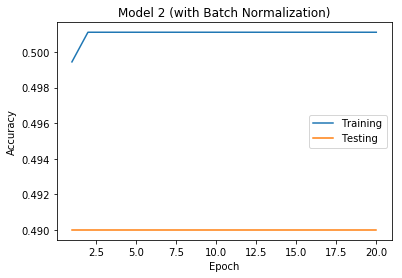

In [14]:
#mode21Hist.acc.append(0.9887)
#mode21Hist.val_acc.append(0.8072)
xVal = np.arange(1, 21, 1)
plt.plot(xVal, mode21Hist.acc)
plt.plot(xVal, mode21Hist.val_acc)
plt.title('Model 2 (with Batch Normalization)')
plt.legend(("Training", "Testing"), loc="best")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Train on 3600 samples, validate on 400 samples
Epoch 1/22
3600/3600 [==============================] - 13s 4ms/step - loss: 8.0411 - acc: 0.5011 - top_3_accuracy: 1.0000 - val_loss: 8.2202 - val_acc: 0.4900 - val_top_3_accuracy: 1.0000


FailedPreconditionError: Attempting to use uninitialized value Adam_3/lr
	 [[{{node _retval_Adam_3/lr_0_0}} = _Retval[T=DT_FLOAT, index=0, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Adam_3/lr)]]